In [22]:
import json
import dspy

import pprint
pprint = pprint.PrettyPrinter(indent=4).pprint

with open('../examples/smart_contract_descriptions/json/data.json', 'r') as f:
    d = json.load(f)

gpt4_turbo = dspy.OpenAI(model='gpt-4-1106-preview', max_tokens=300)
gpt3_turbo = dspy.OpenAI(model='gpt-3.5-turbo-1106', max_tokens=300, temperature=1)

dspy.settings.configure(lm=gpt3_turbo, max_tokens=1024)

In [83]:
import pydantic
from typing import List, Dict, Any


# It is intented to manage tiered VIP memberships, allowing fans to upgrade or downgrade their membership based on the tokens they hold. Define membership levels as Bronze, Silver, and Gold, each with associated perks. Upgrading requires the owner to have a sufficient number of additional tokens (100 tokens for Silver, 200 for Gold). Include functionality for members to voluntarily lower their level, refunding tokens proportionally based on their tenure on the platform (70% if >2 years, 50% if >1 year, 30% if >6 months). Once downgraded, a member must wait 12 days before upgrading again.",

summarized_features3 = ['Levels','Bronze', 'Tokens required','0','Silver','Tokens required','100','Gold', 'Tokens required','200', 'Upgrade cooldown period', '12 days','Downgrade token refund','>2 years', '70%', '>1 year)','50%','>6 months','30%']
summarized_features2 = ['Times bid allowed', '3', 'Mandatory bid incrase', '5%']
summarized_features = ['Max cap', '50,000', 'Personal limit', 'default', '1:1', 'golden', '1:3', 'Buy phases', 'first phase', '5 minutes', 'second phase', '1 week after', 'Cancellation', 'Compensation', 'Golden', '25%', 'Platinum', '5%', 'Bronze', '0%']

examples = [
    dspy.Example(smart_contract_description=d['D1']['descriptions']['description_1'],
                 schematic_data=summarized_features).with_inputs("smart_contract_description"),
    dspy.Example(smart_contract_description=d['D2']['descriptions']['description_1'],
                 schematic_data=summarized_features2).with_inputs("smart_contract_description"),
    dspy.Example(smart_contract_description=d['D3']['descriptions']['description_1'],
                 schematic_data=summarized_features3).with_inputs("smart_contract_description"),
]

class GenerateSchematicData(dspy.Signature):
    """Generate a coherent sequence of terms that robotically explain the description"""
    smart_contract_description: str = dspy.InputField(desc="A description of a Smart Contract")
    schematic_data: List[str] = dspy.OutputField(desc="A list containing schematic data")

class GenerateSchematicDataModule(dspy.Module):

    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.functional.TypedChainOfThought(GenerateSchematicData)

    def forward(self, smart_contract_description: str) -> List[str]:
        return self.generate_answer(smart_contract_description=smart_contract_description)

def metric(example, prediction, trace=None):
    terms = prediction.schematic_data
    return sum([term.count(' ') for term in terms])/len(terms) < 2

from dspy.teleprompt import BootstrapFewShot
config = dict(max_bootstrapped_demos=len(examples)) # max_labeled_demos=4
teleprompter = BootstrapFewShot(metric=metric, **config)
teleprompter.max_errors = 0
optimised_program = teleprompter.compile(GenerateSchematicDataModule(), trainset=examples)
# It doesnt use 'valset' for training (run in Jupyter loads automatically even if changed)

smart_contract_description = d['D2']['descriptions']['description_1']
pred = optimised_program(smart_contract_description)

schematic_data = pred.schematic_data
schematic_data


100%|██████████| 3/3 [00:00<00:00, 89.03it/s]


['Membership Levels',
 'Bronze',
 'Silver',
 'Gold',
 'Upgrade Tokens Required',
 '0',
 '100',
 '200',
 'Downgrade Token Refund',
 '>2 years',
 '70%',
 '>1 year',
 '50%',
 '>6 months',
 '30%',
 'Upgrade Cooldown Period',
 '12 days']

In [85]:
import pydantic
from typing import List

smart_contract_description = d['D3']['descriptions']['description_1']

# class GenerateNodes(dspy.Signature):
#     """Extract a list of 10 short keywords that appear in the smart contract"""
#     smart_contract_description: str = dspy.InputField(desc="A description of a Smart Contract")
#     list_of_features: List[str] = dspy.OutputField(desc="The list of complete terms")

# class GenerateNodesModule(dspy.Module):

#     def __init__(self):
#         super().__init__()
#         self.generate_answer = dspy.functional.TypedChainOfThought(GenerateNodes)

#     def forward(self, smart_contract_description: str) -> List[str]:
#         return self.generate_answer(smart_contract_description=smart_contract_description)

# list_of_features = GenerateNodesModule().forward(smart_contract_description=smart_contract_description).list_of_features

class FilterNodes(dspy.Signature):
    """Basing on the given terms, filter the ones that make reference to them in the context"""
    context: str = dspy.InputField(desc="The contextual smart contract description from where terms come")
    list_of_features: List[str] = dspy.InputField(desc="The list of complete terms")
    feature: str = dspy.InputField(desc="The target term")
    related_features: List[str] = dspy.OutputField(desc="The list of terms")

class FilterNodesModule(dspy.Module):

    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.functional.TypedChainOfThought(FilterNodes)

    def forward(self, context: str, feature: str, list_of_features: List[str]) -> List[str]:
        return self.generate_answer(context=smart_contract_description, feature=feature, list_of_features=list_of_features)

data_dict = {}

for feature in schematic_data:
    lst = schematic_data[:]
    lst.remove(feature)
    pred = FilterNodesModule().forward(context=smart_contract_description, feature=feature, list_of_features=lst)
    data_dict[feature] = pred.related_features

pprint(data_dict)




{   '0': [   'Membership Levels',
             'Bronze',
             'Silver',
             'Gold',
             'Upgrade Tokens Required',
             '100',
             '200',
             'Downgrade Token Refund',
             '>2 years',
             '70%',
             '>1 year',
             '50%',
             '>6 months',
             '30%',
             'Upgrade Cooldown Period',
             '12 days'],
    '100': ['Upgrade Tokens Required'],
    '12 days': ['Upgrade Cooldown Period'],
    '200': ['Upgrade Tokens Required', 'Gold'],
    '30%': ['70%', '50%', '30%'],
    '50%': ['50%'],
    '70%': ['70%'],
    '>1 year': ['50%'],
    '>2 years': ['70%'],
    '>6 months': ['Downgrade Token Refund', '>6 months'],
    'Bronze': ['Membership Levels', 'Bronze'],
    'Downgrade Token Refund': ['70%', '50%', '30%'],
    'Gold': ['Membership Levels', 'Gold'],
    'Membership Levels': ['Bronze', 'Silver', 'Gold'],
    'Silver': ['Membership Levels', 'Silver'],
    'Upgrade Cooldown 

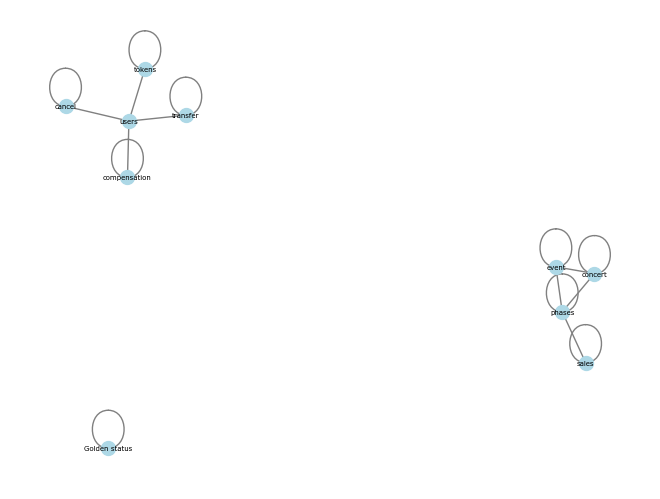

In [41]:

import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph
G = nx.Graph()

# Add nodes and edges from the dictionary
for key, values in data_dict.items():
    for value in values:
        G.add_edge(key, value)

# Draw the network graph
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=100, font_size=5)

# Display the graph
plt.show()
